## Configuration

### Imports

In [168]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

### Support Functions

In [2]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

LIMIT=6*500000
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                    .limit(LIMIT)
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                 #.limit(LIMIT)
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

### Network analysis

#### -- Tweets

In [3]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [4]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [5]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### -- Retweets

In [6]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 3000000


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [7]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          1131
retweet_author    1131
dtype: int64

In [8]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          2998869
retweet_author    2998869
dtype: int64

### -- Users

In [9]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 338669


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000322577469,0.16


In [10]:
len(users._id.unique())

338669

### --- Build directed-weighted retweet graph

In [11]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000000000000001125213258,000000000000000022488241
1,000000000000000250738602,000000000000000022488241
2,000000000000000194176051,000000000000000022488241
3,000000000000000376943216,000000000000000022488241
4,000001121249610612260865,000000000000000022488241


In [12]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000003065,000000000000000016409683,1
1,000000000000000000003065,000000000000000121385551,1
2,000000000000000000003065,000000000000000207741909,1
3,000000000000000000003971,000000000000000006293922,1
4,000000000000000000003971,000000000000000142395787,1


In [16]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)
nx.set_node_attributes(G, values=-1, name='botscore')
node_attr = users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("botscore") <= 1 and data.get("botscore") >= 0
)

H = G.subgraph(nodes)

In [236]:
H.number_of_edges()

1382855

## Network robutness

#### Relationship botscore/random vs % of METRICS

In [222]:
%%time

hubs, authorities = nx.hits(H, normalized=False)

df_if = pd.DataFrame.from_dict({'pagerank (importance)':list(dict(nx.pagerank(H, weight='weight', alpha=0.85)).values()),
                                'hubs (retweeted)':list(dict(hubs).values()),
                                'authorities (retweeting)':list(dict(authorities).values()),
                                'botscore':list(dict(H.nodes(data='botscore')).values()),
                               },
                               orient='columns')

df_if.head()

CPU times: user 23min 10s, sys: 0 ns, total: 23min 10s
Wall time: 23min 10s


,pagerank,hubs,authorities,botscore
0,0.000003,0.000000e+00,5.976516e-06,0.04
1,0.000004,0.000000e+00,1.066404e-04,0.05
2,0.000003,0.000000e+00,1.027306e-07,0.18
3,0.000003,1.629920e-09,6.768707e-04,0.22
4,0.000004,0.000000e+00,5.044175e-11,0.19


In [228]:
normalized_df=(df_if-df_if.min())/(df_if.max()-df_if.min())
normalized_df.head(2)

,pagerank,hubs,authorities,botscore
0,0.000001,0.0,0.000006,0.040404
1,0.001859,0.0,0.000107,0.050505


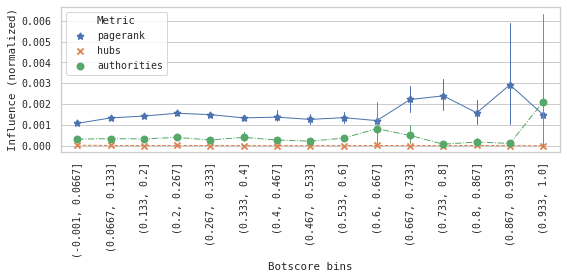

In [259]:
df_pointplot = pd.melt(normalized_df, 
                       id_vars='botscore',
                       var_name='Metric')

df_pointplot['bins_botscore'] = pd.cut(df_pointplot.botscore, bins=15)

fig = plt.figure(figsize=(8,4))

ax = sns.pointplot(data=df_pointplot,
              x='bins_botscore',
              y='value',
              hue='Metric',
              #errwidth=0.5,
              scale=0.9,
              markers=['*','x','o'],
              linestyles=["-", "--", "-."],
              join=True
                  )

ax.set_ylabel(ylabel='Influence (normalized)')
ax.set_xlabel(xlabel='Botscore bins')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.setp(ax.lines,linewidth=1)

"""ins_axes = inset_axes(ax,
            width="30%",
            height="30%", 
                 loc=9)

ins_axes.set_xlabel('Botscore', fontsize='small')
ins_axes.set_ylabel('RMSE', fontsize='small')
ins_axes.tick_params(labelsize=8)
for tick in ins_axes.get_xticklabels():
    tick.set_rotation(90)
plt.setp(ins_axes.lines,linewidth=1)"""

plt.tight_layout()
plt.show()